In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from utils import list_all_files, ffmpeg_load_audio
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter1d as gaussian
import librosa
import numpy as np

In [2]:
files = list(list_all_files('data/birds/samples', ['.wav']))

In [3]:
len(files)

1253

In [4]:
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [11]:
def get_amp(y):
    amp = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
#     amp = amp**.5 # alternative
    amp = librosa.logamplitude(amp**2, ref_power=np.max)
    amp = np.flipud(amp[1:]) # flip and drop dc offset
    amp -= amp.min()
    amp /= amp.max()
    return amp

In [12]:
sr = 44100
n_fft = 256
hop_length = 128
sigma = 30
thresh = .5
plot = False

fingerprints = []
# for fn in files[:5]:
for fn in tqdm(files, leave=True):
    y, sr = ffmpeg_load_audio(fn, sr=sr)
    y = y[0,:] # take left channel
    amp = get_amp(y)
    
    if plot:
        showarray(255 * amp)
    
    rms = amp.max(axis=0)
    rms = gaussian(rms, sigma=sigma)
    rms /= rms.max()
    left = np.argmax(rms>thresh)
    right = len(rms) - np.argmax(rms[::-1]>thresh)
    
    if plot:
        plt.figure(figsize=(30,4))
        plt.plot(rms)
        plt.axvline(left)
        plt.axvline(right)
        plt.show()
    
    y = y[hop_length*left:hop_length*right]
    amp = get_amp(y)
    
    fingerprints.append(amp)
    
    if plot:
        showarray(255 * amp)

100%|██████████| 1253/1253 [01:08<00:00, 18.18it/s]


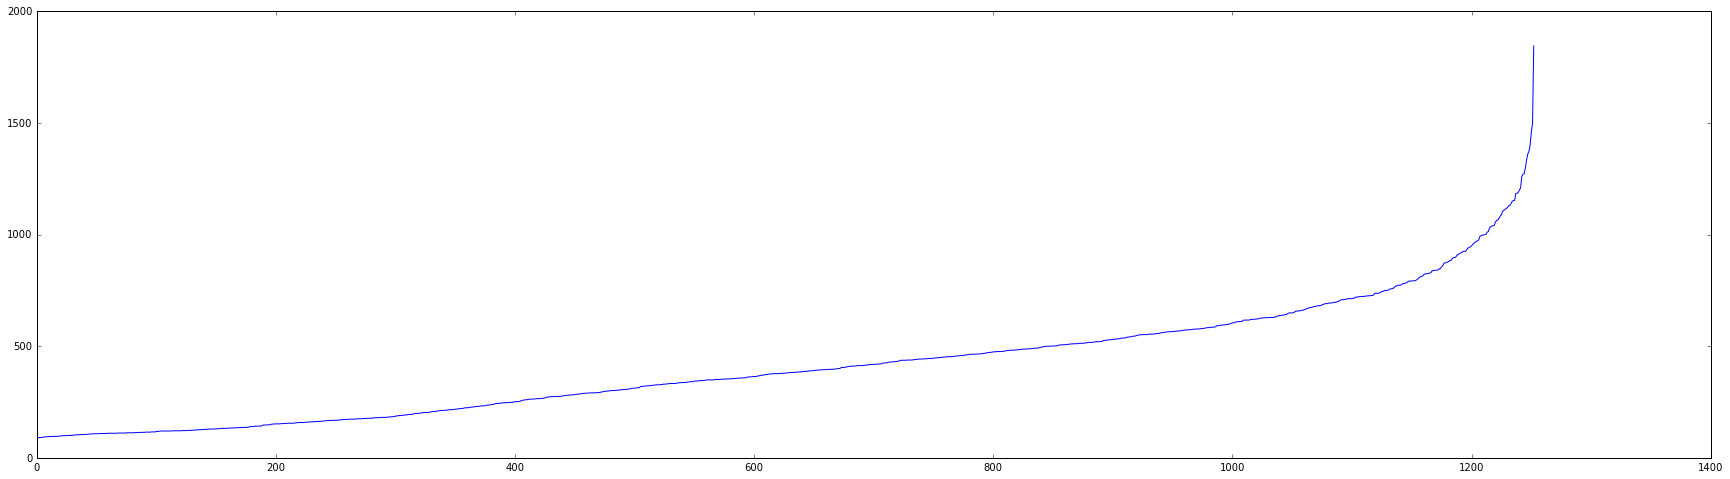

In [54]:
lengths = [s.shape[1] for s in fingerprints]
lengths.sort()
plt.figure(figsize=(30,8))
plt.plot(lengths)

In [13]:
import cPickle as pickle
with open('data/birds/fingerprints-log.pkl', 'wb') as f:
    pickle.dump(fingerprints, f, -1)